In [80]:
from importlib import reload

import numpy as np
from datetime import timedelta
from fiberis.simulator.core import pds

In [81]:
from fiberis.analyzer.Data1D import Data1D_GAUGE, Data1D_PumpingCurve
from fiberis.simulator.core import mesh_utils

In [82]:
datapath = "./data"

In [83]:
# Gauge data
gauge_data_folder = datapath + "/gauge_data_swell"

In [84]:
# Load the pressure gauge data. Most close to the first stage is gauge 6. For the stage 8 I need to use gauge 7.
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"/gauge6_data_swell.npz")
gauge_dataframe_next = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"/gauge7_data_swell.npz")

# Load the pumping curve data (stage7; stage8)
pumping_curve_filepath = datapath + f"/pumping_curve/pumping_curve_stage7.npz"
pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

In [85]:
stage7_start_time = pumping_curve_dataframe.get_start_time()
stage7_end_time = pumping_curve_dataframe.get_end_time()
pumping_curve_filepath_next = datapath + f"/pumping_curve/pumping_curve_stage8.npz"
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath_next)
stage8_start_time = pumping_curve_dataframe_next.get_start_time()
stage8_end_time = pumping_curve_dataframe_next.get_end_time()
# Crop the pressure gauge data
gauge_dataframe.crop(stage7_start_time, stage8_end_time)

In [86]:
# Load the frac hit data
frac_hit_datapath = datapath + "/geometry/frac_hit/"
from pds.DSS_analyzer_Mariner import Data3D_geometry
frac_hit_dataframe_stage7 = Data3D_geometry.Data3D_geometry(frac_hit_datapath + "frac_hit_stage_7_swell.npz")
frac_hit_dataframe_stage8 = Data3D_geometry.Data3D_geometry(frac_hit_datapath + "frac_hit_stage_8_swell.npz")

In [87]:
# Load the gauge md data
gauge_md_datapath = datapath + "/geometry/gauge_md_swell.npz"
gauge_md_dataframe = Data3D_geometry.Data3D_geometry(gauge_md_datapath)

In [88]:
# Extract the frac hit data and gauge md data
frac_hit_md_stg7 = frac_hit_dataframe_stage7.data
frac_hit_md_stg8 = frac_hit_dataframe_stage8.data
gauge_md = gauge_md_dataframe.data[4:10]

In [89]:
print(frac_hit_md_stg8)
print(np.round(frac_hit_md_stg8))

[14940.    14976.36  15009.09  15063.63  15100.    15118.182]
[14940. 14976. 15009. 15064. 15100. 15118.]


In [90]:
# define the mesh
dx = 1
nx = 5500
x = np.arange(12500, 12500 + nx * dx, dx)
# refine the mesh round the frac hits
# stage 7, refine the mesh around frac hits.
for frac_hit_iter in np.round(frac_hit_md_stg7):
    x = mesh_utils.refine_mesh(x, [frac_hit_iter - 1, frac_hit_iter + 1], 5)
# stage 8, refine the mesh around frac hits.
for frac_hit_iter in np.round(frac_hit_md_stg8):
    x = mesh_utils.refine_mesh(x, [frac_hit_iter - 1, frac_hit_iter + 1], 5)

In [91]:
# update the number of nodes
nx = len(x)

In [92]:
# update the frac hit index and gauge index
frac_hit_idx_stg7 = [mesh_utils.locate(x, frac_hit_iter)[0] for frac_hit_iter in frac_hit_md_stg7]
frac_hit_idx_stg8 = [mesh_utils.locate(x, frac_hit_iter)[0] for frac_hit_iter in frac_hit_md_stg8]
gauge_idx = [mesh_utils.locate(x, gauge_iter)[0] for gauge_iter in gauge_md]

In [93]:
import matplotlib.pyplot as plt

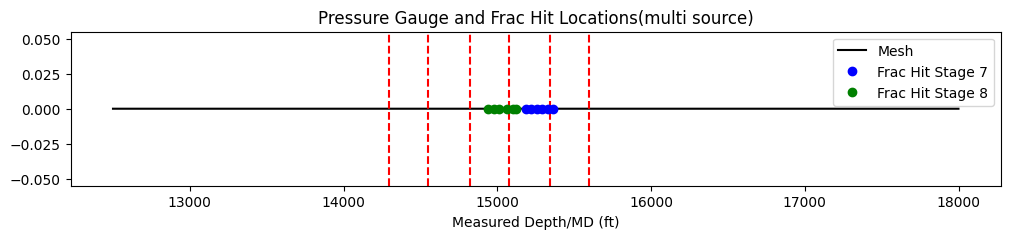

In [94]:
# Plot the location of the pressure gauge and frac hit
plt.figure(figsize=(12, 2))
plt.plot(x, np.zeros_like(x), 'k-', label='Mesh')
for gauge_md_iter in gauge_md:
    # no legend
    plt.axvline(x=gauge_md_iter, color='r', linestyle='--')
plt.plot(frac_hit_md_stg7, np.zeros_like(frac_hit_md_stg7), 'bo', label='Frac Hit Stage 7')
plt.plot(frac_hit_md_stg8, np.zeros_like(frac_hit_md_stg8), 'go', label='Frac Hit Stage 8')
plt.xlabel('Measured Depth/MD (ft)')
plt.title('Pressure Gauge and Frac Hit Locations(multi source)')
plt.legend()
plt.show()

In [95]:
# Set other parameters
d = 140
d_array = np.ones_like(x) * d

t0 = 0 # Phase 1 starts at 0

# Phase 1

In [96]:
pds_frame_phase1 = pds.PDS1D_MultiSource()

In [97]:
pds_frame_phase1.set_mesh(x)
pds_frame_phase1.set_diffusivity(d_array)
pds_frame_phase1.set_bcs('Neumann', 'Neumann')
pds_frame_phase1.set_t0(t0) # Phase 1 starts at 0

In [98]:
# Set the source idx
pds_frame_phase1.set_sourceidx(frac_hit_idx_stg7)

In [99]:
# Process the pressure gauge data to get the source term
phase_1_pg_dataframe = gauge_dataframe.copy()
phase_1_pg_dataframe.crop(stage7_start_time, stage7_end_time)

In [100]:
# Create the source term array
source_phase1_list = []
for source_iter in range(len(frac_hit_idx_stg7)):
    source_phase1_list.append(phase_1_pg_dataframe)

In [101]:
pds_frame_phase1.set_source(source_phase1_list)

In [102]:
u_initial = np.zeros(nx)
u_initial += phase_1_pg_dataframe.data[0]
pds_frame_phase1.set_initial(u_initial)

In [103]:
pds_frame_phase1.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.
Time: 2 Source term: [9604.148, 9604.148, 9604.148, 9604.148, 9604.148, 9604.148]
Time: 32 Source term: [9604.07056412729, 9604.07056412729, 9604.07056412729, 9604.07056412729, 9604.07056412729, 9604.07056412729]
Time: 62 Source term: [9603.273238642298, 9603.273238642298, 9603.273238642298, 9603.273238642298, 9603.273238642298, 9603.273238642298]
Time: 92 Source term: [9602.47516989796, 9602.47516989796, 9602.47516989796, 9602.47516989796, 9602.47516989796, 9602.47516989796]
Time: 122 Source term: [9601.682737190813, 9601.682737190813, 9601.682737190813, 9601.682737190813, 9601.682737190813, 9601.682737190813]
Time: 152 Source term: [9600.86372284264, 9600.86372284264, 9600.86372284264, 9600.86372284264, 9600.86372284264, 9600.86372284264]
Time: 182 Source term: [9600.477121347203, 9600.477121347203, 9600.477121347203, 9600.477121347203, 9600.477121347203, 9600.477121347203]
Time: 212 Source term: [9602.09012320917, 9602.09012320917, 9602.09

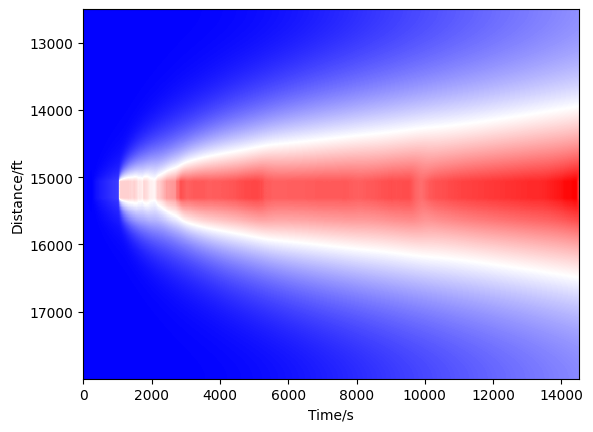

In [104]:
# show the solution
pds_frame_phase1.plot_solution()

# Phase 2

In [105]:
# from importlib import reload
# reload(pds)

In [106]:
# Calculate the total_time
total_time = stage8_start_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [107]:
pds_frame_phase2 = pds.PDS1D_MultiSource()

In [108]:
pds_frame_phase2.set_mesh(x)
pds_frame_phase2.set_diffusivity(d_array)
pds_frame_phase2.set_bcs('Neumann', 'Neumann')

In [109]:
pds_frame_phase2.set_t0(pds_frame_phase1.taxis[-1]) # Phase 2 starts after phase 1

In [110]:
pds_frame_phase2.set_sourceidx(frac_hit_idx_stg7)

In [111]:
# setup the source term for phase 2
phase_2_pg_dataframe = gauge_dataframe.copy()
phase_2_pg_dataframe.crop(stage7_end_time, stage8_start_time)

In [112]:
source_phase2_list = []
for source_iter in range(len(frac_hit_idx_stg7)):
    source_phase2_list.append(phase_2_pg_dataframe)

In [113]:
pds_frame_phase2.set_source(source_phase2_list)

In [114]:
u_initial = pds_frame_phase1.snapshot[-1]
pds_frame_phase2.set_initial(u_initial)

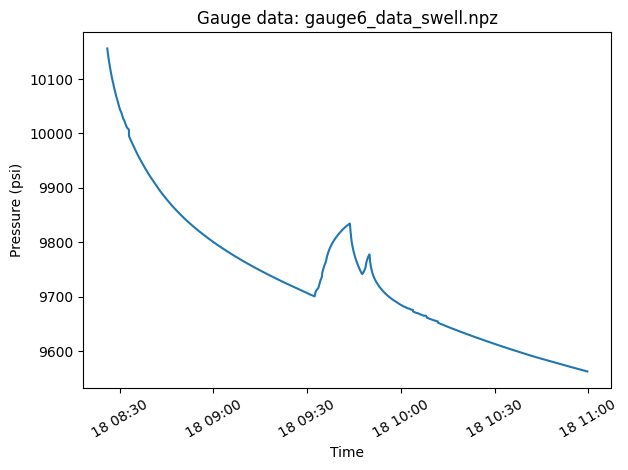

In [115]:
phase_2_pg_dataframe.plot_simple()

In [116]:
pds_frame_phase2.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.
Time: 14524 Source term: [10156.084, 10156.084, 10156.084, 10156.084, 10156.084, 10156.084]
Time: 14551.429788474958 Source term: [10154.145334322453, 10154.145334322453, 10154.145334322453, 10154.145334322453, 10154.145334322453, 10154.145334322453]
Time: 14581.429788474958 Source term: [10135.071274711472, 10135.071274711472, 10135.071274711472, 10135.071274711472, 10135.071274711472, 10135.071274711472]
Time: 14611.429788474958 Source term: [10117.214412037292, 10117.214412037292, 10117.214412037292, 10117.214412037292, 10117.214412037292, 10117.214412037292]
Time: 14641.429788474958 Source term: [10102.346634348734, 10102.346634348734, 10102.346634348734, 10102.346634348734, 10102.346634348734, 10102.346634348734]
Time: 14671.429788474958 Source term: [10088.847511319726, 10088.847511319726, 10088.847511319726, 10088.847511319726, 10088.847511319726, 10088.847511319726]
Time: 14701.429788474958 Source term: [10077.004961948756, 10077.0049

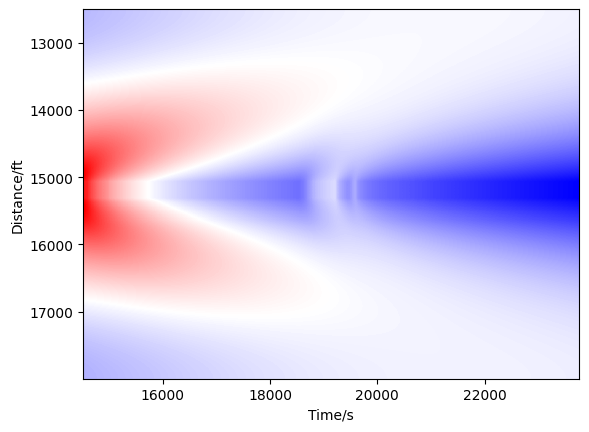

In [117]:
pds_frame_phase2.plot_solution()

# Phase 3

In [118]:
# Change diffusivity ratio
diffusivity_change_ratio = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001]) # add more instances

In [119]:
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [120]:
# First for test, only use the first diffusivity ratio
pds_frame_phase3 = pds.PDS1D_MultiSource()
pds_frame_phase3.set_mesh(x)
pds_frame_phase3.set_bcs('Neumann', 'Neumann')
pds_frame_phase3.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2

In [121]:
pds_frame_phase3.set_sourceidx(frac_hit_idx_stg8)

In [122]:
# Set the diffusivity
d_pahse3 = np.ones_like(x) * d
# change the diffusivity at the frac hit location at stage 7
for frac_hit_idx_iter in frac_hit_idx_stg7:
    d_pahse3[frac_hit_idx_iter] = d * diffusivity_change_ratio[-1]
pds_frame_phase3.set_diffusivity(d_pahse3)

In [123]:
phase_3_pg_dataframe = gauge_dataframe_next.copy()
phase_3_pg_dataframe.crop(stage8_start_time, stage8_end_time)

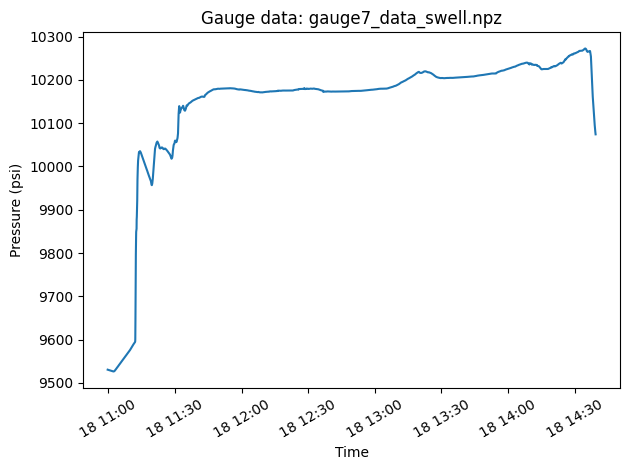

In [124]:
phase_3_pg_dataframe.plot_simple()

In [125]:
source_phase3_list = []
for source_iter in range(len(frac_hit_idx_stg8)):
    source_phase3_list.append(phase_3_pg_dataframe)

In [126]:
pds_frame_phase3.set_source(source_phase3_list)

In [127]:
u_initial = pds_frame_phase2.snapshot[-1]

In [128]:
pds_frame_phase3.set_initial(u_initial)

In [129]:
pds_frame_phase3.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.
Time: 23763.429788474958 Source term: [9530.631, 9530.631, 9530.631, 9530.631, 9530.631, 9530.631]
Time: 23768.875164390345 Source term: [9530.574, 9530.574, 9530.574, 9530.574, 9530.574, 9530.574]
Time: 23791.05459162372 Source term: [9530.439914151779, 9530.439914151779, 9530.439914151779, 9530.439914151779, 9530.439914151779, 9530.439914151779]
Time: 23821.05459162372 Source term: [9529.830279633885, 9529.830279633885, 9529.830279633885, 9529.830279633885, 9529.830279633885, 9529.830279633885]
Time: 23851.05459162372 Source term: [9528.982936719975, 9528.982936719975, 9528.982936719975, 9528.982936719975, 9528.982936719975, 9528.982936719975]
Time: 23881.05459162372 Source term: [9528.163166190821, 9528.163166190821, 9528.163166190821, 9528.163166190821, 9528.163166190821, 9528.163166190821]
Time: 23911.05459162372 Source term: [9527.31622253589, 9527.31622253589, 9527.31622253589, 9527.31622253589, 9527.31622253589, 9527.31622253589]
Time

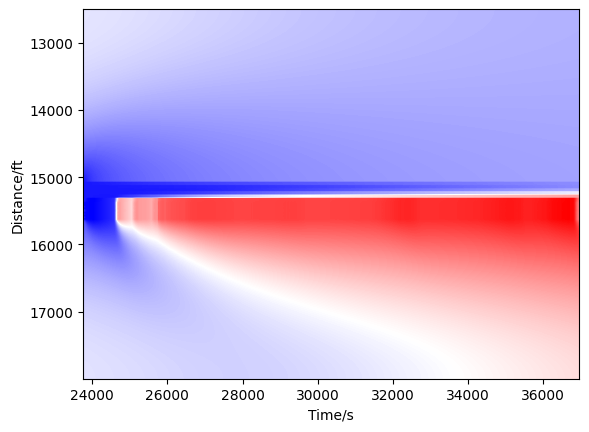

In [130]:
pds_frame_phase3.plot_solution()

# Phase 3 / Full

In [131]:
# Use all the diffusivity ratio to do the simulation.
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [132]:
# Initialize the phase 3 full solution
pds_frame_phase3_all = []

In [133]:
for diffusivity_iter in diffusivity_change_ratio[:-1]: # exclude the last one since it is already done in the previous cell
    pds_frame_phase3_iter = pds.PDS1D_MultiSource()
    pds_frame_phase3_iter.set_mesh(x)
    pds_frame_phase3_iter.set_bcs('Neumann', 'Neumann')
    pds_frame_phase3_iter.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2
    # Set the source index
    pds_frame_phase3_iter.set_sourceidx(frac_hit_idx_stg8)
    # Set the diffusivity
    d_pahse3 = np.ones_like(x) * d
    # change the diffusivity at the frac hit location at stage 7
    for frac_hit_idx_iter in frac_hit_idx_stg7:
        d_pahse3[frac_hit_idx_iter] = d * diffusivity_iter
    pds_frame_phase3_iter.set_diffusivity(d_pahse3)
    # Set the source term
    phase_3_pg_dataframe = gauge_dataframe_next.copy()
    phase_3_pg_dataframe.crop(stage8_start_time, stage8_end_time)
    source_phase3_list = []
    for source_iter in range(len(frac_hit_idx_stg8)):
        source_phase3_list.append(phase_3_pg_dataframe)
    pds_frame_phase3_iter.set_source(source_phase3_list)
    # Set the initial condition
    u_initial = pds_frame_phase2.snapshot[-1]
    pds_frame_phase3_iter.set_initial(u_initial)
    # Solve the problem
    pds_frame_phase3_iter.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)
    # Append the solution
    pds_frame_phase3_all.append(pds_frame_phase3_iter)

Time array generated using the source term.
Time: 23763.429788474958 Source term: [9530.631, 9530.631, 9530.631, 9530.631, 9530.631, 9530.631]
Time: 23768.87632827888 Source term: [9530.574, 9530.574, 9530.574, 9530.574, 9530.574, 9530.574]
Time: 23790.982264823662 Source term: [9530.439879408837, 9530.439879408837, 9530.439879408837, 9530.439879408837, 9530.439879408837, 9530.439879408837]
Time: 23820.982264823662 Source term: [9529.83237451911, 9529.83237451911, 9529.83237451911, 9529.83237451911, 9529.83237451911, 9529.83237451911]
Time: 23850.982264823662 Source term: [9528.985250883714, 9528.985250883714, 9528.985250883714, 9528.985250883714, 9528.985250883714, 9528.985250883714]
Time: 23880.982264823662 Source term: [9528.16549335548, 9528.16549335548, 9528.16549335548, 9528.16549335548, 9528.16549335548, 9528.16549335548]
Time: 23910.982264823662 Source term: [9527.318648592078, 9527.318648592078, 9527.318648592078, 9527.318648592078, 9527.318648592078, 9527.318648592078]
Time: 

# Post-processing

Convert it to strain rate

In [134]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([pds_frame_phase1.snapshot, pds_frame_phase2.snapshot], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, pds_frame_phase3.snapshot], axis=0)

In [135]:
# Combine the results -> taxis
taxis_result_all = np.concatenate([pds_frame_phase1.taxis, pds_frame_phase2.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, pds_frame_phase3.taxis], axis=0)

In [136]:
np.unique(np.diff(x))

array([0.13333333, 0.13333333, 1.        ])

In [137]:
extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]]

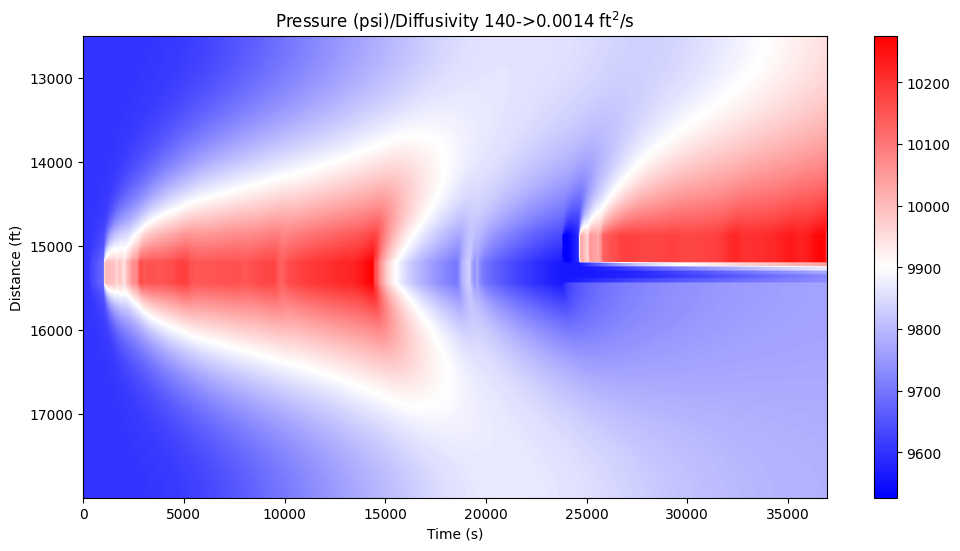

In [138]:
# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(snapshot_result_all.T, aspect='auto', cmap='bwr', extent=extent)
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title(f'Pressure (psi)/Diffusivity {d}->{d*diffusivity_change_ratio[-1]:.4f} ft$^2$/s')
plt.show()

## Convert the pressure field to strain rate

In [139]:
pressure_data_psi = snapshot_result_all
pressure_data_pa = pressure_data_psi * 6894.76
strain_from_pressure = pressure_data_pa / 30e9 # Hook's law

In [140]:
strain_rate_from_simulation = np.zeros_like(strain_from_pressure)
for i in range(strain_from_pressure.shape[1]):
    strain_rate_from_simulation[:, i] = np.gradient(strain_from_pressure[:, i], axis=0) / np.gradient(taxis_result_all)

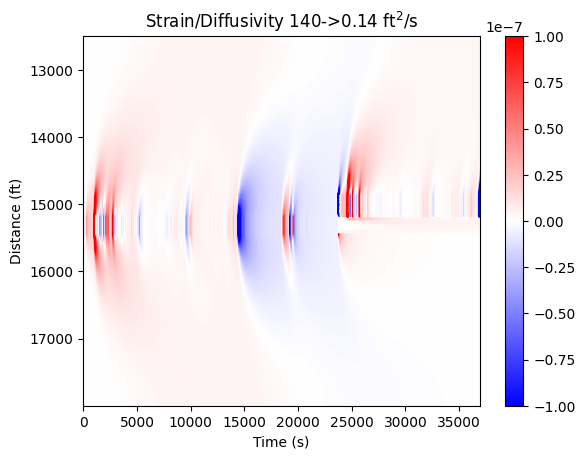

In [141]:
# Plot the solution
ax  = np.array([-1, 1])
plt.imshow(strain_rate_from_simulation.T, aspect='auto', cmap='bwr', extent=extent)
plt.clim(ax * 1e-7)
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Strain/Diffusivity 140->0.14 ft$^2$/s')
plt.show()

## Load DSS data

In [142]:
from DSS_analyzer_Mariner import Data2D_XT_DSS

In [143]:
import os

In [144]:
# Compare the results with the DAS data
DASdata_folder = datapath + "/DASdata/"
os.listdir(DASdata_folder)

['LFDASdata_stg8_swell.npz',
 'LFDASdata_stg7_interval_swell.npz',
 'LFDASdata_stg7_swell.npz']

In [145]:
stg7_DASdata = Data2D_XT_DSS.Data2D()
stg7_DASdata.loadnpz(DASdata_folder + "LFDASdata_stg7_swell.npz")

In [146]:
stg7_DASdata_interval = Data2D_XT_DSS.Data2D()
stg7_DASdata_interval.loadnpz(DASdata_folder + "LFDASdata_stg7_interval_swell.npz")

In [147]:
stg8_DASdata = Data2D_XT_DSS.Data2D()
stg8_DASdata.loadnpz(DASdata_folder + "LFDASdata_stg8_swell.npz")

In [148]:
# merge the DAS data
# DASdata_new = Data2D_XT_DSS.merge_data2D([DASdata, DASdata_interval, DASdata_next])
DASdata_all = Data2D_XT_DSS.merge_data2D([stg7_DASdata, stg7_DASdata_interval, stg8_DASdata])

In [149]:
depth_range = [np.min(frac_hit_md_stg8) - 500, np.max(frac_hit_md_stg7) + 500]

In [150]:
DASdata_all.select_depth(depth_range[0], depth_range[1])

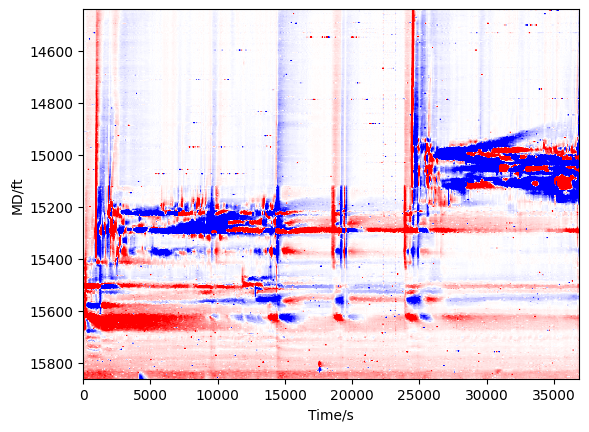

In [151]:
cx = np.array([-1, 1])
DASdata_all.plot_waterfall(use_timestamp=False)
plt.clim(cx * 1e3)
plt.xlabel("Time/s")
plt.ylabel("MD/ft")
plt.show()

## Compare the results

In [152]:
# Crop the simulation data
ind = (x >= depth_range[0]) & (x <= depth_range[1])
strain_rate_from_simulation_crop = strain_rate_from_simulation[:, ind]
x_crop = x[ind]

In [153]:
extent_crop = [extent[0], extent[1], x_crop[-1], x_crop[0]]

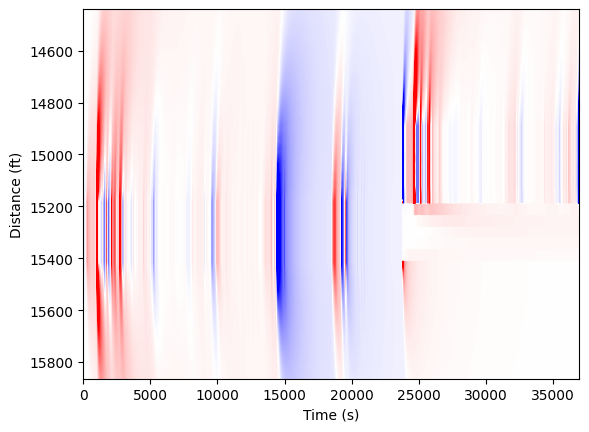

In [154]:
# Plot the solution
ax  = np.array([-1, 1])
plt.imshow(strain_rate_from_simulation_crop.T, aspect='auto', cmap='bwr', extent=extent_crop)
plt.clim(ax * 1e-7)
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.show()

## Compare the simulation with the gauge data

In [155]:
mesh_utils.locate(x, gauge_md[0])

(3255, 15599.0)

In [156]:
# Load the real pressure gauge data
real_pg_data = []
real_pg_data_taxis = []
gauge_num = [5, 6, 7, 8, 9, 10]
for num in gauge_num:
    gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"/gauge{num}_data_swell.npz")
    gauge_dataframe.crop(stage7_start_time, stage8_end_time)
    time_sec = gauge_dataframe.calculate_time() * 3600
    real_pg_data.append(gauge_dataframe.data)
    real_pg_data_taxis.append(time_sec)

In [157]:
gauge_md

array([15599, 15344, 15075, 14821, 14552, 14297])

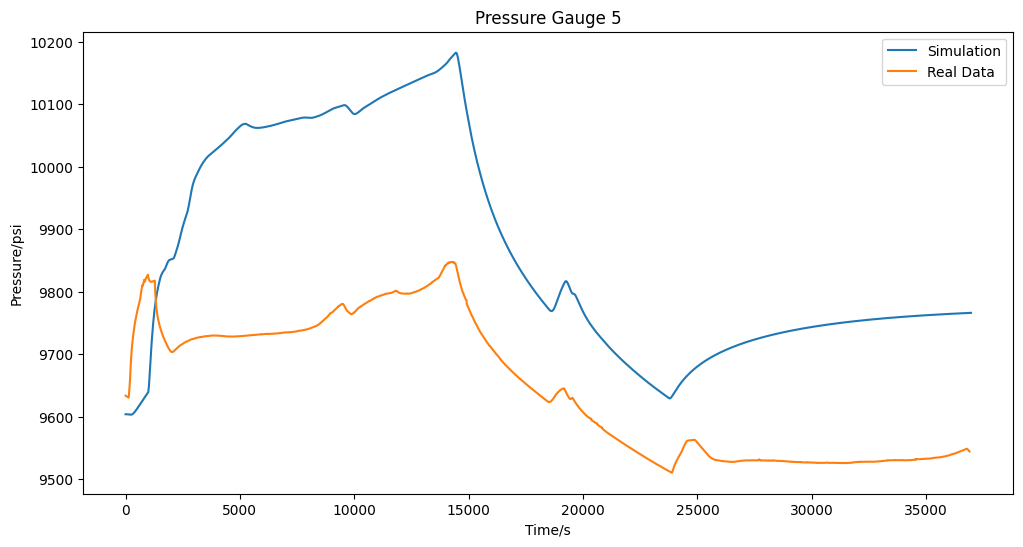

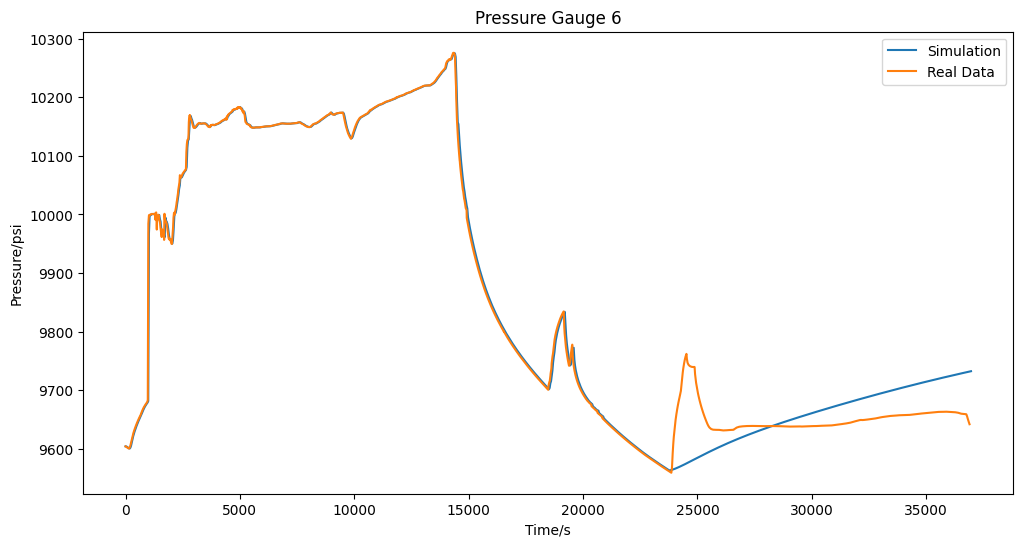

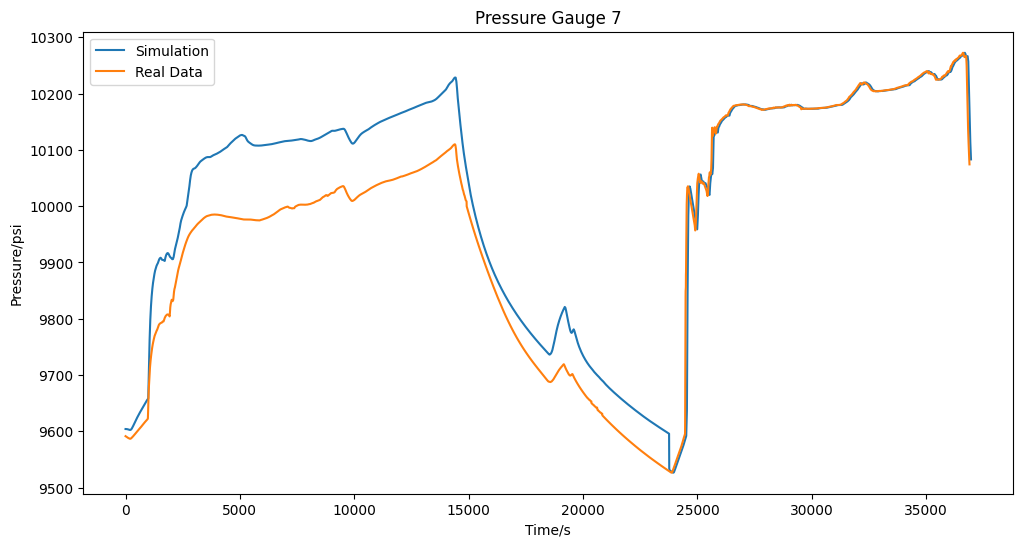

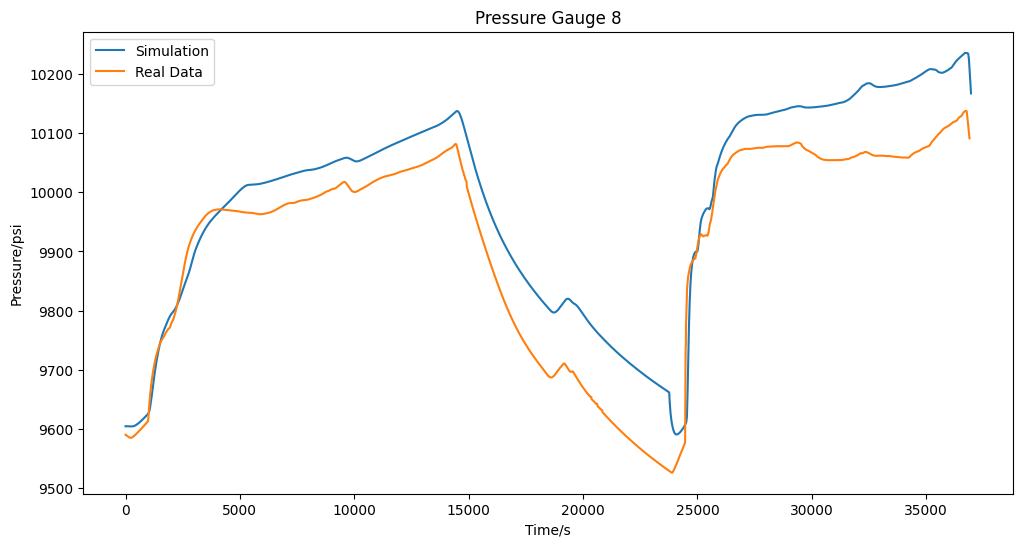

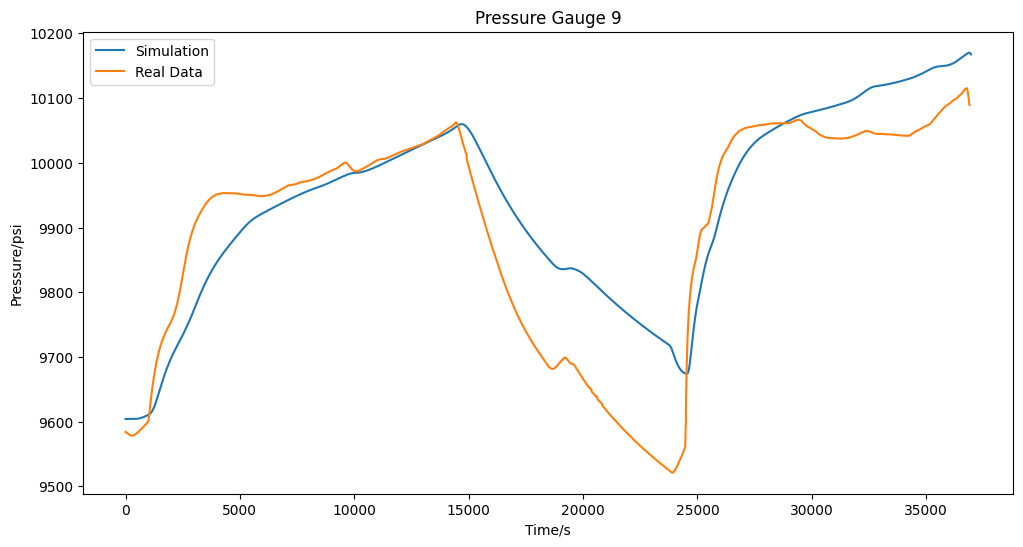

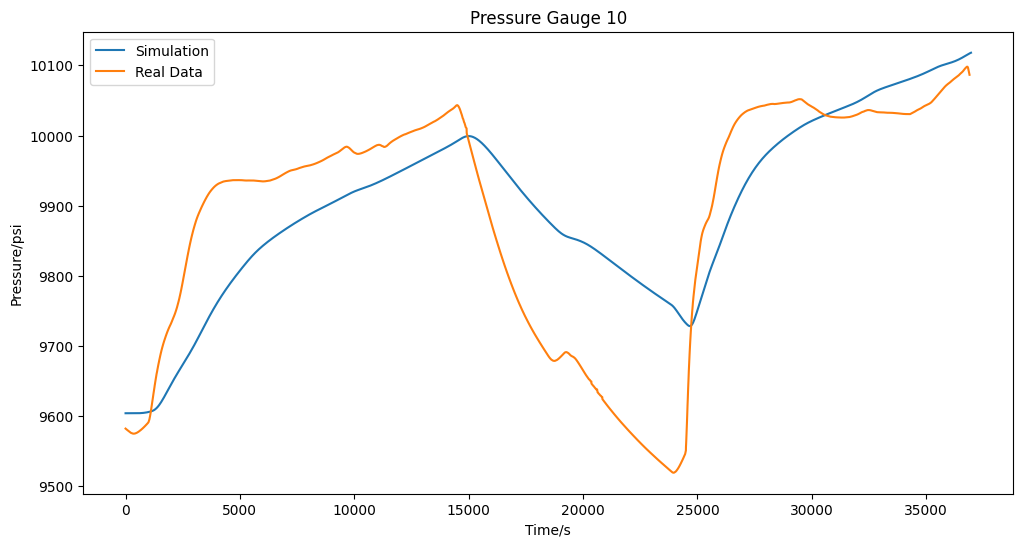

In [158]:
flag = 0
for gauge_iter in gauge_md:
    # Locate the gauge
    gauge_idx = mesh_utils.locate(x, gauge_iter)[0]
    # Plot the simulation result
    plt.figure(figsize=(12, 6))
    plt.plot(taxis_result_all, snapshot_result_all[:, gauge_idx], label='Simulation')
    # Plot the real data
    plt.plot(real_pg_data_taxis[flag], real_pg_data[flag], label='Real Data')
    plt.xlabel('Time/s')
    plt.ylabel('Pressure/psi')
    plt.title(f'Pressure Gauge {flag + 5}')
    plt.legend()
    plt.show()

    flag += 1
